In [87]:
import os
import fnmatch
import random
from pathlib import Path
import numpy as np
from matplotlib import cm
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import time

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [73]:
class CityScapes(Dataset):
    def __init__(self, root, train=True):
        self.train = train
        self.root = os.path.expanduser(root)
        self.data_path = root + ('/train' if train else '/val')
        self.data_len = len(fnmatch.filter(os.listdir(self.data_path + '/image'), '*.npy'))
        # Values from the training set
        self.min_depth = 1.5259021893143654e-05
        self.max_depth = 0.4922102689743042

    def __getitem__(self, index):
        image = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/image/{:d}.npy'.format(index)), -1, 0))
        depth = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/depth/{:d}.npy'.format(index)), -1, 0))
        depth = self._process_depth(depth)
        return image.float(), depth.float()

    def __len__(self):
        return self.data_len
    
    def _process_depth(self, depth: np.ndarray) -> torch.Tensor:
        d = depth.squeeze()
        d_filled = np.where(d == 0, self.min_depth, d)
        d_norm = (d_filled - self.min_depth) / (self.max_depth - self.min_depth)
        return torch.from_numpy(d_norm).unsqueeze(0).float()

In [74]:
def model_fit(x_pred, x_output):
    if x_pred.shape != x_output.shape:
        x_pred = F.interpolate(x_pred, size=x_output.shape[2:], mode='bilinear', align_corners=False)
    x_pred = torch.clamp(x_pred, 0.0, 1.0)
    binary_mask = (torch.sum(x_output, dim=1) != 0).float().unsqueeze(1).to(x_pred.device)
    loss = torch.sum(torch.abs(x_pred - x_output) * binary_mask) / torch.nonzero(binary_mask, as_tuple=False).size(0)
    return loss

In [75]:
def depth_error(x_pred, x_output):
    if x_pred.shape != x_output.shape:
        x_pred = F.interpolate(x_pred, size=x_output.shape[2:], mode='bilinear', align_corners=False)
    x_pred = torch.clamp(x_pred, 0.0, 1.0)
    binary_mask = (torch.sum(x_output, dim=1) != 0).unsqueeze(1).to(x_pred.device)
    x_pred_true = x_pred.masked_select(binary_mask)
    x_output_true = x_output.masked_select(binary_mask)
    eps = 1e-6
    abs_err = torch.abs(x_pred_true - x_output_true)
    rel_err = abs_err / (x_output_true + eps)
    valid_pixel_count = torch.nonzero(binary_mask, as_tuple=False).size(0)
    return (torch.sum(abs_err) / valid_pixel_count).item(), \
           (torch.sum(rel_err) / valid_pixel_count).item()

In [76]:
def depth_trainer(train_loader, test_loader, model, device, optimizer, scheduler, total_epoch=100):
    for epoch in range(total_epoch):
        model.train()
        train_loss, train_abs, train_rel = 0, 0, 0
        for img, depth in train_loader:
            img, depth = img.to(device), depth.to(device)
            pred = model(img)[0][0]
            loss = model_fit(pred, depth)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            abs_err, rel_err = depth_error(pred, depth)
            train_loss += loss.item()
            train_abs += abs_err
            train_rel += rel_err
        model.eval()
        test_loss, test_abs, test_rel = 0, 0, 0
        with torch.no_grad():
            for img, depth in test_loader:
                img, depth = img.to(device), depth.to(device)
                pred = model(img)[0][0]
                loss = model_fit(pred, depth)
                abs_err, rel_err = depth_error(pred, depth)
                test_loss += loss.item()
                test_abs += abs_err
                test_rel += rel_err
        scheduler.step()
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f}, Abs: {train_abs:.4f}, Rel: {train_rel:.4f} || "
              f"Test Loss: {test_loss:.4f}, Abs: {test_abs:.4f}, Rel: {test_rel:.4f}")

In [77]:
class DepthNet(nn.Module):
    def __init__(self):
        super(DepthNet, self).__init__()
        filters = [64, 128, 256, 512]
        self.enc1 = self.conv_block(3, filters[0])
        self.enc2 = self.conv_block(filters[0], filters[1])
        self.enc3 = self.conv_block(filters[1], filters[2])
        self.enc4 = self.conv_block(filters[2], filters[3])
        self.dec4 = self.up_block(filters[3], filters[2])
        self.dec3 = self.up_block(filters[2], filters[1])
        self.dec2 = self.up_block(filters[1], filters[0])
        self.dec1 = self.up_block(filters[0], filters[0])
        self.final = nn.Conv2d(filters[0], 1, kernel_size=1)
        self.pool = nn.MaxPool2d(2, 2)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        d4 = self.dec4(e4)
        d3 = self.dec3(d4 + e3)
        d2 = self.dec2(d3 + e2)
        d1 = self.dec1(d2 + e1)
        out = self.final(d1)
        return [out], None

In [78]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = DepthNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
dataset_path = '..//data'
train_set = CityScapes(root=dataset_path, train=True)
test_set = CityScapes(root=dataset_path, train=False)
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
# depth_trainer(train_loader, test_loader, model, device, optimizer, scheduler)
# torch.save(model.state_dict(), '..\\src\\models\\weights\\depthnet_weights2.pth')

cuda:0


In [79]:
model = DepthNet()
model.load_state_dict(torch.load('..\\src\\models\\weights\\depthnet_weights2.pth'))
model.to(device)
model.eval()

DepthNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tra

C:\Users\mikim\AppData\Local\Temp\ipykernel_17244\3074817795.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno   = cm.get_cmap('inferno')


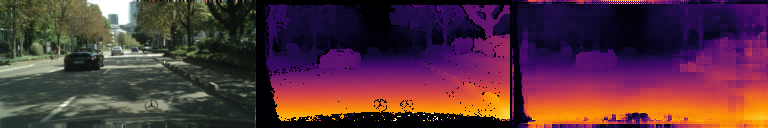

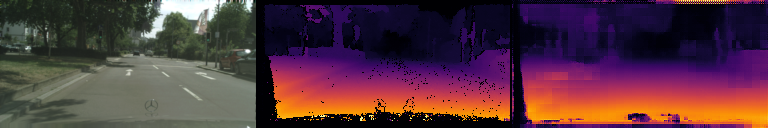

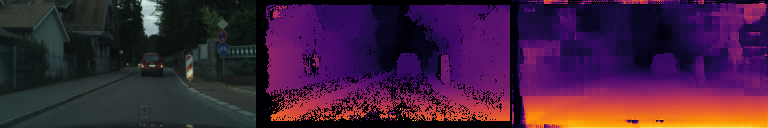

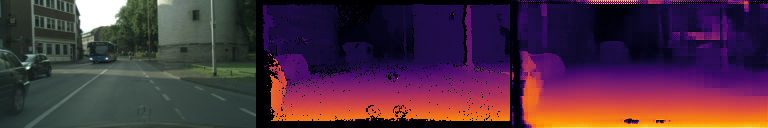

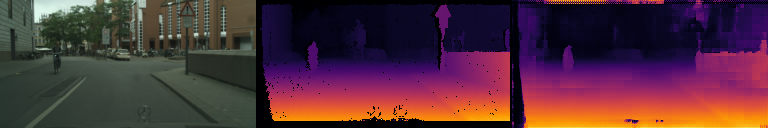

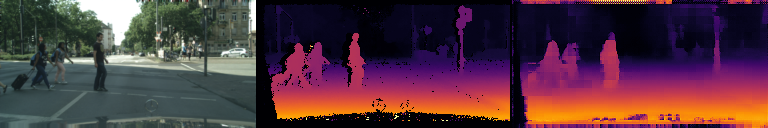

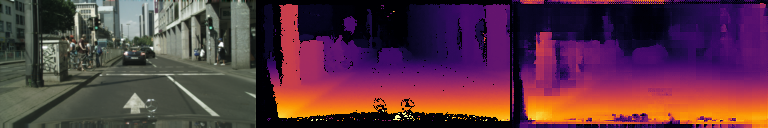

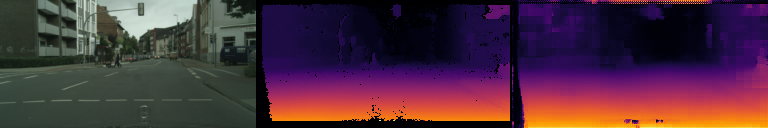

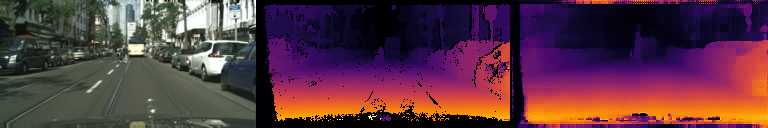

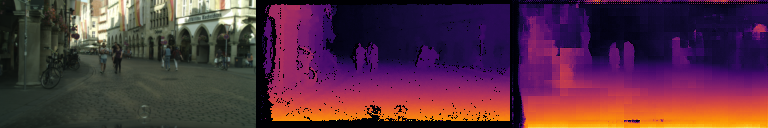

In [80]:
MIN_DEPTH = 1.5259021893143654e-05
MAX_DEPTH = 0.4922102689743042
VALID_DIR = Path(dataset_path) / 'val'
n_files   = 10
files     = random.sample(os.listdir(VALID_DIR / 'image'), n_files)
inferno   = cm.get_cmap('inferno')

def depth_to_rgb(depth: np.ndarray) -> np.ndarray:
    depth = depth.squeeze()
    depth = np.clip(depth, 0, 1)
    rgb = inferno(depth)[..., :3]
    return (rgb * 255).astype(np.uint8)

def normalize_depth(depth: np.ndarray) -> np.ndarray:
    depth = depth.squeeze()
    depth_filled = np.where(depth == 0, MIN_DEPTH, depth)
    depth_norm = (depth_filled - MIN_DEPTH) / (MAX_DEPTH - MIN_DEPTH)
    return np.clip(depth_norm, 0, 1)

model.eval()
with torch.no_grad():
    for file in files:
        img_np = np.load(VALID_DIR / 'image' / file)
        h, w = img_np.shape[:2]
        img_tensor = torch.from_numpy(
            np.expand_dims(np.moveaxis(img_np, -1, 0), axis=0)
        ).float().to(device)
        prediction, _ = model(img_tensor)
        pred_resized = F.interpolate(prediction[0], size=(h, w), mode='bicubic', align_corners=False)
        depth_pred = pred_resized[0].cpu().detach().numpy().transpose(1, 2, 0)
        depth_pred = np.clip(depth_pred, 0, 1)
        depth_label = np.load(VALID_DIR / 'depth' / file)
        depth_label_norm = normalize_depth(depth_label)
        img_disp = (img_np.clip(0, 1) * 255).astype(np.uint8) if img_np.dtype != np.uint8 else img_np
        depth_label_rgb = depth_to_rgb(depth_label_norm)
        depth_pred_rgb = depth_to_rgb(depth_pred)
        panel = np.concatenate([img_disp, depth_label_rgb, depth_pred_rgb], axis=1)
        display(Image.fromarray(panel))

## Knowledge distillation 

In [81]:
class StudentDepthNet(nn.Module):
    def __init__(self):
        super(StudentDepthNet, self).__init__()
        filters = [32, 64, 128, 256]  # Reduced capacity
        self.enc1 = self.conv_block(3, filters[0])
        self.enc2 = self.conv_block(filters[0], filters[1])
        self.enc3 = self.conv_block(filters[1], filters[2])
        self.enc4 = self.conv_block(filters[2], filters[3])
        self.dec4 = self.up_block(filters[3], filters[2])
        self.dec3 = self.up_block(filters[2], filters[1])
        self.dec2 = self.up_block(filters[1], filters[0])
        self.dec1 = self.up_block(filters[0], filters[0])
        self.final = nn.Conv2d(filters[0], 1, kernel_size=1)
        self.pool = nn.MaxPool2d(2, 2)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        d4 = self.dec4(e4)
        d3 = self.dec3(d4 + e3)
        d2 = self.dec2(d3 + e2)
        d1 = self.dec1(d2 + e1)
        out = self.final(d1)
        return [out], None

In [82]:
def student_model_fit(student_pred, teacher_pred, gt, alpha=0.5):
    if student_pred.shape != gt.shape:
        student_pred = F.interpolate(student_pred, size=gt.shape[2:], mode='bilinear', align_corners=False)
    if teacher_pred.shape != gt.shape:
        teacher_pred = F.interpolate(teacher_pred, size=gt.shape[2:], mode='bilinear', align_corners=False)
    student_pred = torch.clamp(student_pred, 0.0, 1.0)
    teacher_pred = torch.clamp(teacher_pred, 0.0, 1.0)
    mask = (torch.sum(gt, dim=1) != 0).float().unsqueeze(1).to(gt.device)
    valid_count = torch.nonzero(mask, as_tuple=False).size(0)
    l_gt = torch.sum(torch.abs(student_pred - gt) * mask) / valid_count
    l_distill = torch.sum(torch.abs(student_pred - teacher_pred.detach()) * mask) / valid_count
    return (1 - alpha) * l_gt + alpha * l_distill

In [83]:
def student_trainer(train_loader, test_loader, teacher, student, device, optimizer, scheduler, total_epoch=100, alpha=0.5):
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False
    for epoch in range(total_epoch):
        student.train()
        train_loss, train_abs, train_rel = 0, 0, 0

        for img, depth in train_loader:
            img, depth = img.to(device), depth.to(device)
            with torch.no_grad():
                teacher_pred = teacher(img)[0][0]
            student_pred = student(img)[0][0]
            loss = student_model_fit(student_pred, teacher_pred, gt=depth, alpha=alpha)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            abs_err, rel_err = depth_error(student_pred, depth)
            train_loss += loss.item()
            train_abs += abs_err
            train_rel += rel_err
        student.eval()
        test_loss, test_abs, test_rel = 0, 0, 0
        with torch.no_grad():
            for img, depth in test_loader:
                img, depth = img.to(device), depth.to(device)
                student_pred = student(img)[0][0]
                teacher_pred = teacher(img)[0][0]
                loss = student_model_fit(student_pred, teacher_pred, gt=depth, alpha=alpha)
                abs_err, rel_err = depth_error(student_pred, depth)
                test_loss += loss.item()
                test_abs += abs_err
                test_rel += rel_err
        scheduler.step()
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f}, Abs: {train_abs:.4f}, Rel: {train_rel:.4f} || "
              f"Test Loss: {test_loss:.4f}, Abs: {test_abs:.4f}, Rel: {test_rel:.4f}")

In [84]:
teacher = DepthNet().to(device)
teacher.load_state_dict(torch.load('..\\src\\models\\weights\\depthnet_weights2.pth'))
teacher.eval()
student = StudentDepthNet().to(device)
optimizer = optim.Adam(student.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
student_trainer(train_loader, test_loader, teacher, student, device, optimizer, scheduler, total_epoch=100, alpha=0.5)
torch.save(student.state_dict(), "..\\src\\models\\weights\\student_depthnet2.pth")

Epoch 000 | Train Loss: 26.7284, Abs: 26.9135, Rel: 184.4299 || Test Loss: 3.5692, Abs: 3.8137, Rel: 27.2105
Epoch 001 | Train Loss: 18.5785, Abs: 18.8234, Rel: 135.5652 || Test Loss: 3.0904, Abs: 3.3515, Rel: 28.9921
Epoch 002 | Train Loss: 16.6670, Abs: 16.9452, Rel: 122.3934 || Test Loss: 2.7627, Abs: 3.0651, Rel: 23.2329
Epoch 003 | Train Loss: 15.6123, Abs: 15.9118, Rel: 116.1616 || Test Loss: 2.4995, Abs: 2.7874, Rel: 21.0257
Epoch 004 | Train Loss: 14.5370, Abs: 14.8556, Rel: 109.0228 || Test Loss: 2.3673, Abs: 2.6696, Rel: 20.3843
Epoch 005 | Train Loss: 14.1870, Abs: 14.5163, Rel: 106.7165 || Test Loss: 2.5448, Abs: 2.8488, Rel: 26.1455
Epoch 006 | Train Loss: 13.5691, Abs: 13.9109, Rel: 102.7788 || Test Loss: 2.2227, Abs: 2.5341, Rel: 18.8270
Epoch 007 | Train Loss: 13.1126, Abs: 13.4646, Rel: 98.8521 || Test Loss: 2.1127, Abs: 2.4351, Rel: 18.8179
Epoch 008 | Train Loss: 12.7378, Abs: 13.1020, Rel: 97.3541 || Test Loss: 2.2541, Abs: 2.5670, Rel: 21.8377
Epoch 009 | Train Los

C:\Users\mikim\AppData\Local\Temp\ipykernel_17244\1746181401.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno   = cm.get_cmap('inferno')


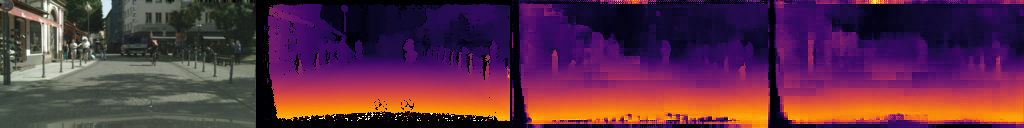

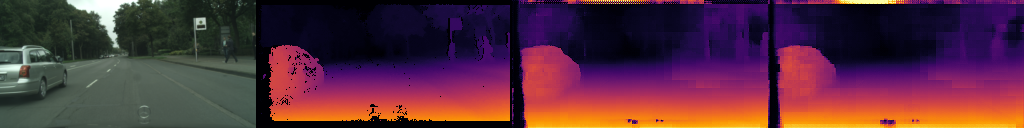

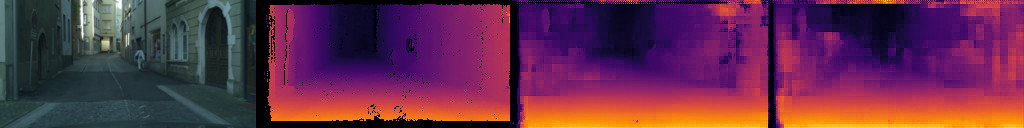

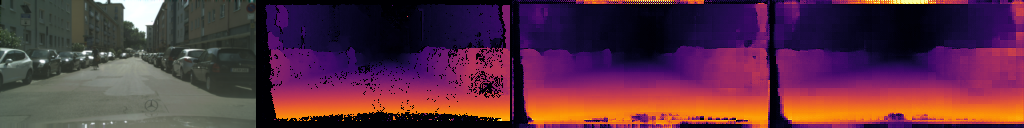

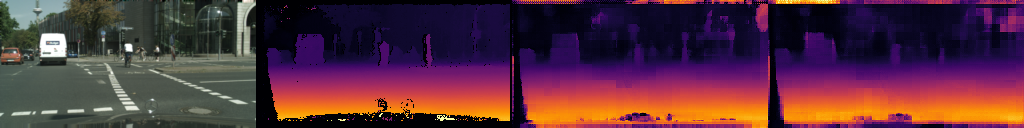

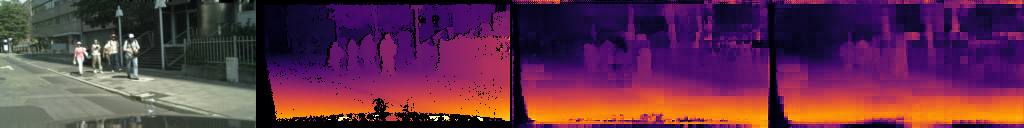

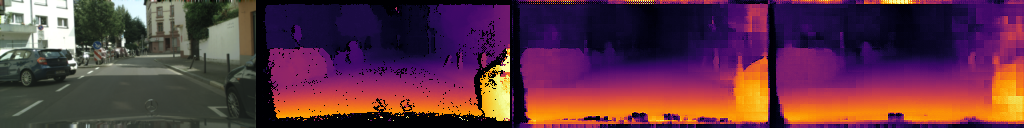

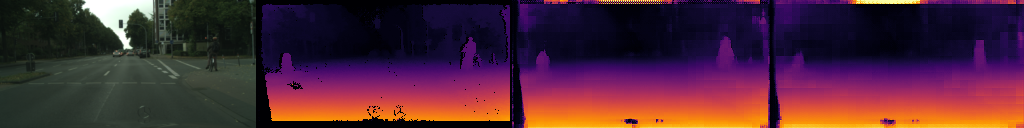

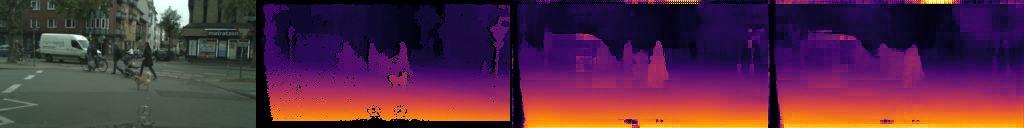

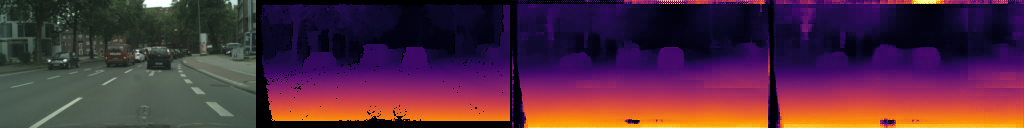

In [85]:
MIN_DEPTH = 1.5259021893143654e-05
MAX_DEPTH = 0.4922102689743042
VALID_DIR = Path(dataset_path) / 'val'
n_files   = 10
files     = random.sample(os.listdir(VALID_DIR / 'image'), n_files)
inferno   = cm.get_cmap('inferno')

def depth_to_rgb(depth: np.ndarray) -> np.ndarray:
    depth = depth.squeeze()
    depth = np.clip(depth, 0, 1)
    rgb = inferno(depth)[..., :3]
    return (rgb * 255).astype(np.uint8)

def normalize_depth(depth: np.ndarray) -> np.ndarray:
    depth = depth.squeeze()
    depth_filled = np.where(depth == 0, MIN_DEPTH, depth)
    depth_norm = (depth_filled - MIN_DEPTH) / (MAX_DEPTH - MIN_DEPTH)
    return np.clip(depth_norm, 0, 1)

teacher = DepthNet().to(device)
teacher.load_state_dict(torch.load('..\\src\\models\\weights\\depthnet_weights2.pth'))
teacher.eval()
student = StudentDepthNet().to(device)
student.load_state_dict(torch.load("..\\src\\models\\weights\\student_depthnet2.pth"))
student.eval()

with torch.no_grad():
    for file in files:
        img_np = np.load(VALID_DIR / 'image' / file)
        h, w = img_np.shape[:2]
        img_tensor = torch.from_numpy(
            np.expand_dims(np.moveaxis(img_np, -1, 0), axis=0)
        ).float().to(device)
        teacher_pred = teacher(img_tensor)[0][0]
        teacher_pred = F.interpolate(teacher_pred, size=(h, w), mode='bicubic', align_corners=False)
        teacher_pred_np = teacher_pred[0].cpu().numpy().transpose(1, 2, 0)
        teacher_pred_np = np.clip(teacher_pred_np, 0, 1)
        student_pred = student(img_tensor)[0][0]
        student_pred = F.interpolate(student_pred, size=(h, w), mode='bicubic', align_corners=False)
        student_pred_np = student_pred[0].cpu().numpy().transpose(1, 2, 0)
        student_pred_np = np.clip(student_pred_np, 0, 1)
        depth_label = np.load(VALID_DIR / 'depth' / file)
        depth_label_norm = normalize_depth(depth_label)
        img_disp         = (img_np.clip(0, 1) * 255).astype(np.uint8) if img_np.dtype != np.uint8 else img_np
        depth_label_rgb  = depth_to_rgb(depth_label_norm)
        teacher_pred_rgb = depth_to_rgb(teacher_pred_np)
        student_pred_rgb = depth_to_rgb(student_pred_np)
        panel = np.concatenate([img_disp, depth_label_rgb, teacher_pred_rgb, student_pred_rgb], axis=1)
        display(Image.fromarray(panel))

In [93]:
def load_and_preprocess(file_path, device):
    img = np.load(file_path)
    tensor = torch.from_numpy(np.expand_dims(np.moveaxis(img, -1, 0), axis=0)).float().to(device)
    return tensor

def benchmark_model(model, files, device):
    model.eval()
    times = []
    with torch.no_grad():
        for run in range(NUM_RUNS):
            start = time.time()
            for file in files:
                img_tensor = load_and_preprocess(VALID_DIR / file, device)
                _ = model(img_tensor)[0][0]
            torch.cuda.synchronize() if device.type == "cuda" else None
            elapsed = time.time() - start
            times.append(elapsed / len(files))
    return times


NUM_RUNS = 10
NUM_IMAGES = 100
VALID_DIR = Path(dataset_path) / "val" / "image"
all_files = sorted([f for f in os.listdir(VALID_DIR) if f.endswith(".npy")])
files = all_files[:NUM_IMAGES]
teacher = DepthNet().to(device)
teacher.load_state_dict(torch.load('..\\src\\models\\weights\\depthnet_weights2.pth'))
student = StudentDepthNet().to(device)
student.load_state_dict(torch.load("..\\src\\models\\weights\\student_depthnet2.pth"))
teacher_times = benchmark_model(teacher, files, device)
student_times = benchmark_model(student, files, device)

teacher_cpu = DepthNet().to("cpu")
teacher_cpu.load_state_dict(torch.load('..\\src\\models\\weights\\depthnet_weights2.pth', map_location="cpu"))
student_cpu = StudentDepthNet().to("cpu")
student_cpu.load_state_dict(torch.load("..\\src\\models\\weights\\student_depthnet2.pth", map_location="cpu"))
teacher_cpu_times = benchmark_model(teacher_cpu, files, device=torch.device("cpu"))
student_cpu_times = benchmark_model(student_cpu, files, device=torch.device("cpu"))

print(f"\n--- Inference Benchmark over {NUM_IMAGES} images for {NUM_RUNS} runs ---")
print(f"Device: GPU ({device})")
print(f"  Teacher: Mean = {np.mean(teacher_times)*1000:.2f} ms, Std = {np.std(teacher_times)*1000:.2f} ms")
print(f"  Student: Mean = {np.mean(student_times)*1000:.2f} ms, Std = {np.std(student_times)*1000:.2f} ms")
print(f"\nDevice: CPU")
print(f"  Teacher: Mean = {np.mean(teacher_cpu_times)*1000:.2f} ms, Std = {np.std(teacher_cpu_times)*1000:.2f} ms")
print(f"  Student: Mean = {np.mean(student_cpu_times)*1000:.2f} ms, Std = {np.std(student_cpu_times)*1000:.2f} ms")


--- Inference Benchmark over 100 images for 10 runs ---
Device: GPU (cuda:0)
  Teacher: Mean = 3.78 ms, Std = 0.67 ms
  Student: Mean = 2.11 ms, Std = 0.05 ms

Device: CPU
  Teacher: Mean = 274.08 ms, Std = 4.50 ms
  Student: Mean = 86.60 ms, Std = 0.40 ms
